# Aufgabe - Hautfarbe

In dieser Aufgabe geht es um die Klassifikation von Pixeln in Hautfarbe.
Implementieren Sie die mit `#TODO` gekennzeichneten Codestellen und beantworten Sie die mit `#TODO` gekennzeichneten Fragen.
Beachten Sie ggf. die Hinweise. 

## Teil 1

* Worauf müssen Sie bei der Berechnung des Skin Locus achten, um einen Programmabsturz zu vermeiden?

Es kann vorkommen, dass der Wert Schwarz vorkommt und somit alle rgb channels gleich 0 sind. Bei der Normalisierung würde man also bei dem berechnen der normalisierten rgb Werte durch 0 teilen müssen. In dem Kontext ist es sinnvoll diese  Werte herauszunehmen, da sie sich nicht in dem plot darstellen lassen.

## Teil 2

Im Code unten werden aus einer Datei 8344 hautfarbene Pixel geladen.
Visualisieren Sie diese Pixel in der rg-Ebene.

* Was fällt Ihnen im Vergleich zum Skin-Locus aus dem Skript auf? 

Es gibt einige outlier, die vielleicht durch externe Umstände wie Rauschen, Editierung etc. zu stande kommen können. Auch sehen die Raumgrenzen, im Gegensatz zum Skript nicht sehr stetig aus, aber das liegt wohl auch an der recht geringen sample size.

Loaded 8344 skin pixels!


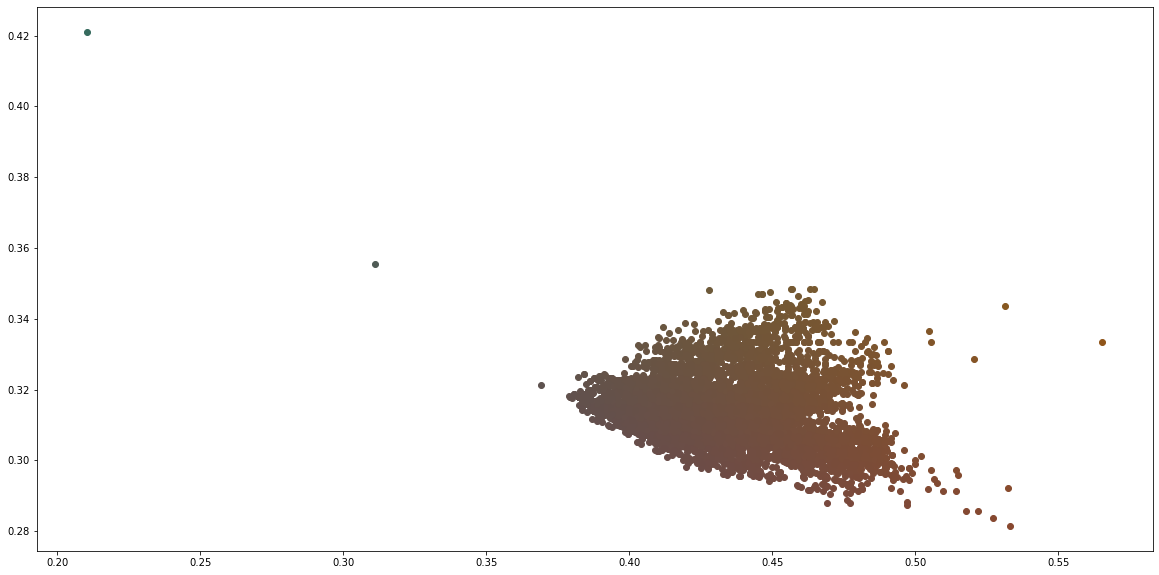

In [49]:
import os

import numpy as np
import cv2 as cv

%matplotlib inline
import matplotlib.pyplot as plt


dir_resources = '../resources'
storage = cv.FileStorage(os.path.join(dir_resources, 'skin_color.yml'), cv.FILE_STORAGE_READ)
skin_pixels = storage.getNode('skin').mat()
storage.release()
print(f'Loaded {skin_pixels.shape[0]} skin pixels!')


def displaySkinPixels(skin_pixels, with_color):
    pixelCount = skin_pixels.shape[0]
    #save all pixels that can be displayed in an list
    normalizedRGPixels = []
    for pixel in range(pixelCount):
        rgb_sum = int(skin_pixels[pixel][0]) + int(skin_pixels[pixel][1]) + int(skin_pixels[pixel][2])
        if rgb_sum != 0: #black pixel (0,0,0)can not be displayed 
            r_channel = np.divide(int(skin_pixels[pixel][2]), rgb_sum) # bgr in open cv
            g_channel = np.divide(int(skin_pixels[pixel][1]), rgb_sum)
            normalizedRGPixels.append([r_channel,g_channel])
    normalizedRGPixelsArray = np.array(normalizedRGPixels)
    
    #plot image
    plt.figure(figsize=(20,10))
    for r_channel, g_channel in normalizedRGPixelsArray:
        if(with_color):
            #displays normalized pixel colors
            b_channel = 1 - r_channel - g_channel
            rgb = (r_channel,g_channel, b_channel)
            plt.scatter(r_channel, g_channel, c=[rgb])
        else:
            #display every pixel as black
            plt.scatter(r_channel, g_channel, c=[(0,0,0)])

displaySkinPixels(skin_pixels,True)
 

## Teil 3

Erstellen Sie einen eigenen Datensatz an Hautfarbenen Pixeln.
Führen Sie dafür die Code-Zelle unter diesem Text aus.
Das startet ein kleines Tool in dem Sie mit zwei linken Mausklicks rechteckige Regionen markieren können.
Markieren Sie auf den Gesichtsbildern ein Paar solcher Rechtecke, die hautfarbene Pixel enthalten.

Implementieren Sie das `#TODO` in der zweiten Code-Zelle unter diesem Text indem Sie den Code aus **Teil 2** erneut verwenden.
Vergleichen Sie den so entstandenen Skin-Locus mit dem aus dem Skript.

* Was gibt es für Unterschiede und was könnten Gründe für diese Unterschiede sein?

Man sieht eher eine größere Varianz an der Grün Achse. Es sieht so aus als wäre der R wert für fast alle Pixel ähnlich, somit eine sehr geringe Varianz.
Die Pixel sind farblich alle näher beieinander. Das könnte daran liegen, dass das Sample nicht repräsentativ für die Diversität alle Hautfarben ist. 
Die Outliers sind vielleicht durch das Rauschen entstanden oder schwarze Schatten.

<IPython.core.display.Javascript object>


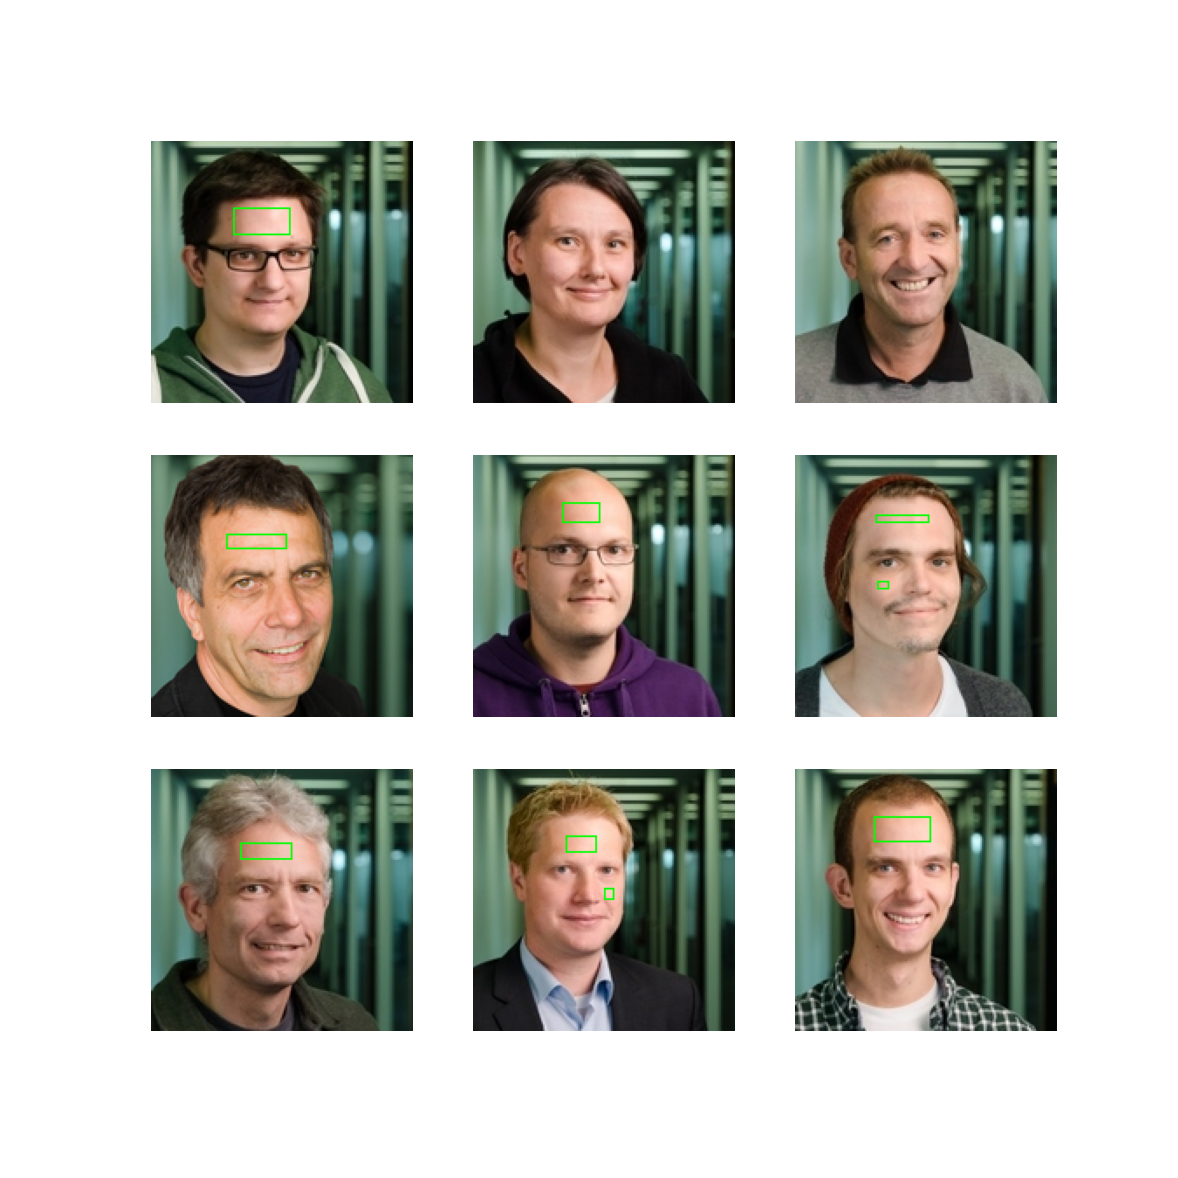

In [19]:
%matplotlib notebook
import os
from util import PixelSelectionTool

dir_images = os.path.join(dir_resources, 'skin_images')
images = [os.path.join(dir_images, img_name) for img_name in os.listdir(dir_images)]

skin_pixels_own = []
pixel_selection_tool = PixelSelectionTool(images[:9], figsize=(12, 12), visualize_rect=False)
_ = pixel_selection_tool.on_new_pixels(lambda new_pixels: skin_pixels_own.extend(new_pixels))

Annotated 2019 skin pixels!


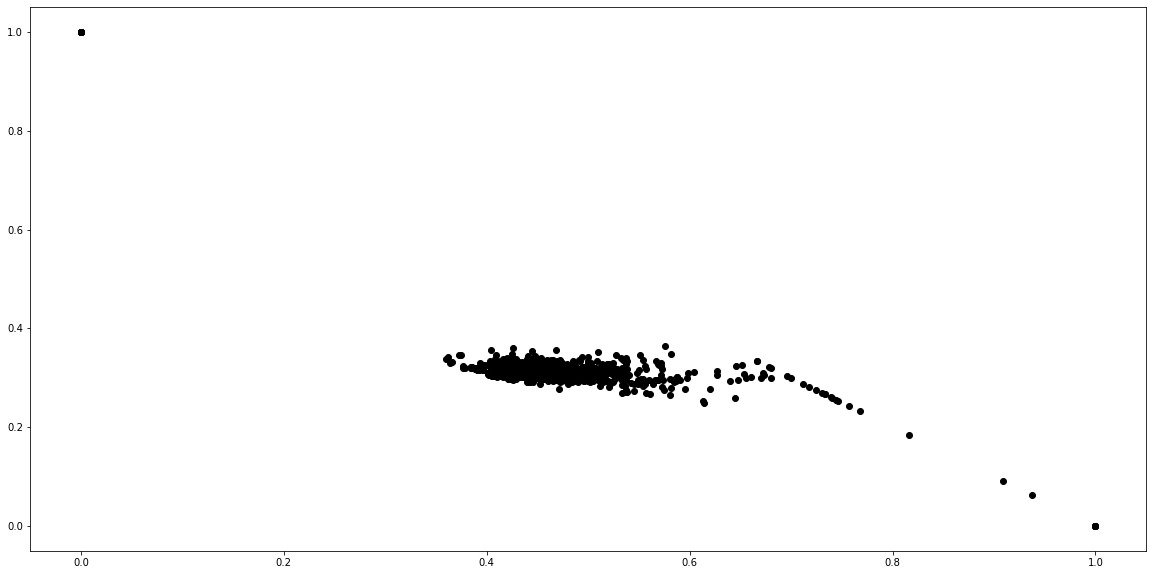

In [50]:
%matplotlib inline

skin_pixels_own = np.array(skin_pixels_own)
print(f'Annotated {skin_pixels_own.shape[0]} skin pixels!')
displaySkinPixels(skin_pixels_own, False)

## Teil 4
* Um eine effiziente Klassifikation in hautfarbene und nicht-hautfarbene Pixel durchzuführen, approximiert man die Ränder des Skin Locus mittels zweier Parabeln ($ax^2 + bx + c$). Wie kann man die Parameter dieser Parabeln sinnvoll bestimmen?

Dies ist mit polynomieller Regression 2. Grades möglich. Also man bestimmt das Minimum der Fehlerfunktion abhängig von a,b und c. Die Fehlerfunktion berechnet meistens die durchschnittliche quadratische Abweichung zwischen dem Wert der Parabel und den Punkten. Die Punkte die man für die Regression verwendet sollten möglichst maximal bzw minimal sein. Das könnte man beispielweise erreicht, wenn man die x-Achse in bins unterteilt und den maximalen bzw  minimalen Y-Wert aus diesen bins auswählt.

* Wie kann die Klassifikation in hautfarbene und nicht-hautfarbene Pixel noch effizienter als über die Approximation von Parabeln realisiert werden und was sind Nachteile eines solchen Verfahrens gegenüber den Parabeln?

Man könnte einen Cluster Algorithmus verwenden, welcher testet, ob ein Punkt zu dem skin locus Cluster gehört oder nicht.

* Meist befindet sich die Farbe weiß ($r=g=0.33$) innerhalb des Skin Locus. Wie könnte man vorgehen um solche Flaschklassifikationen zu vermeiden?

In dem man weiße Punkte vorher aussortiert/ausschließt und nicht versucht diese zu klassifizieren.

## Teil 5


Ein anderer Hautfarbenklassifikator ist durch die folgenden Regeln definiert [(Peer et al., 2003, "Human skin color clustering for face detection", EUROCON2003)](https://ieeexplore.ieee.org/abstract/document/1248169):

$$(r > 95) \land (g > 40) \land (b > 20) \\ \land (max\{r,g,b\}-min\{r,g,b\} > 15) \\ \land (|r-g|>15) \land (r>g) \land (r>b)$$

Implementieren Sie diesen Klassifikator und visualisieren Sie erneut die von ihm als Hautfarbe klassifizierten Pixel in der rg-Ebene, indem Sie die `#TODOs` in der Code-Zelle unter dem Text implementieren.
Führen Sie danach die Code-Zelle darunter aus, um sich die Ergebnisse des Klassifikators auf Gesichtsbildern anzeigen zu lassen.

* Was fällt Ihnen auf?

Es gibt eine weite Streuung auf beiden Achsen. Es werden potenziell mehr Farben als Haut klassifiziert als beim skin locus. Und es gibt lineare Trennlinien.

* Was sind Vorteile und Nachteile dieses Klassifikators?

Die Klassifikation erfolgt schnell und einfach. Wahrscheinlich ist die Genauigkeit durch den linearen Verlauf der Kanten nicht optimal.

3192
8448


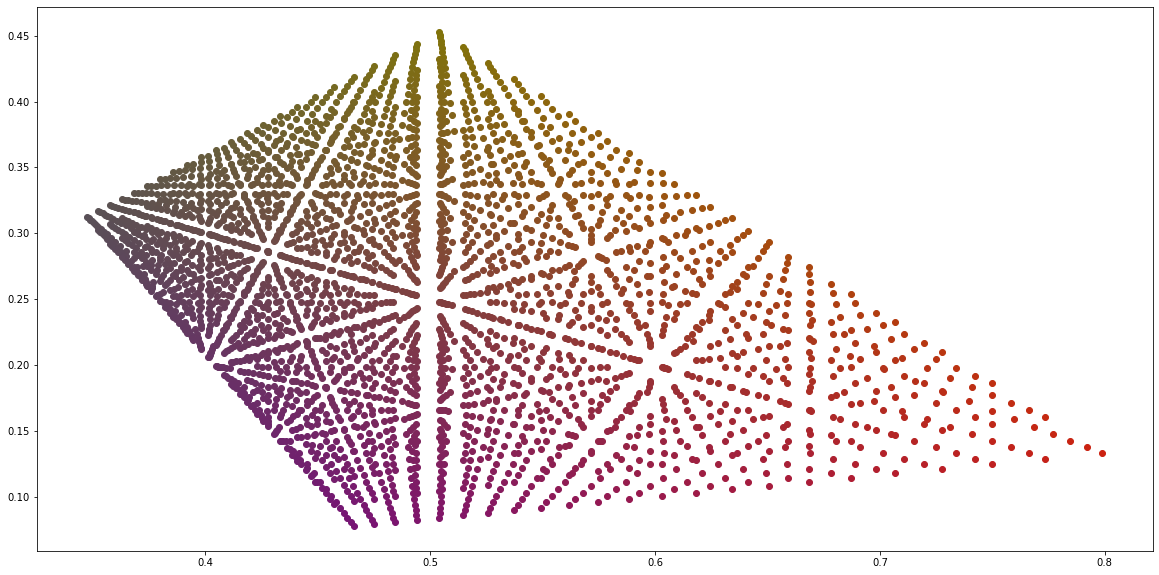

In [63]:
%matplotlib inline

def is_skin(pixel):
    b = int(pixel[0])
    g = int(pixel[1])
    r = int(pixel[2])
    return r > 95 and g > 40 and b > 20 and np.max(pixel) - np.min(pixel) > 15 and np.abs(r - g) > 15 and r > g and r > b

skin_pixels_cls = []
all_pixels = []
for r in range(96, 256, 10):
    for g in range(41, 256, 10):
        for b in range(21, 256, 10):
            pixel = np.array((b, g, r))
            all_pixels.append(pixel)
            if is_skin(pixel):
                skin_pixels_cls.append(pixel)

displaySkinPixels(np.array(skin_pixels_cls), True)

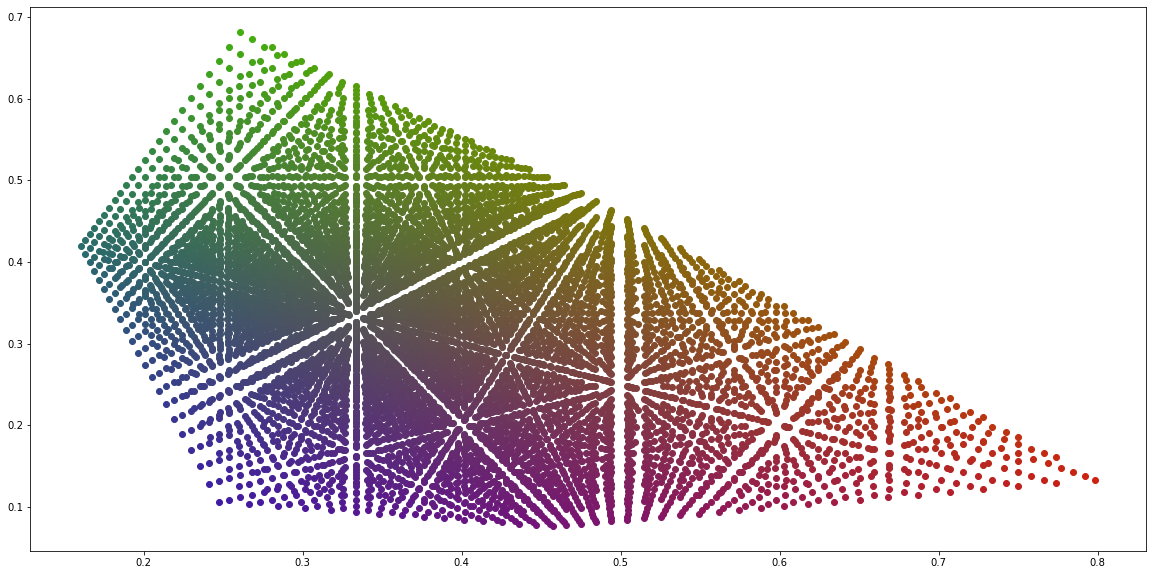

In [64]:
#display all colors from the specified range above
displaySkinPixels(np.array(all_pixels), True)

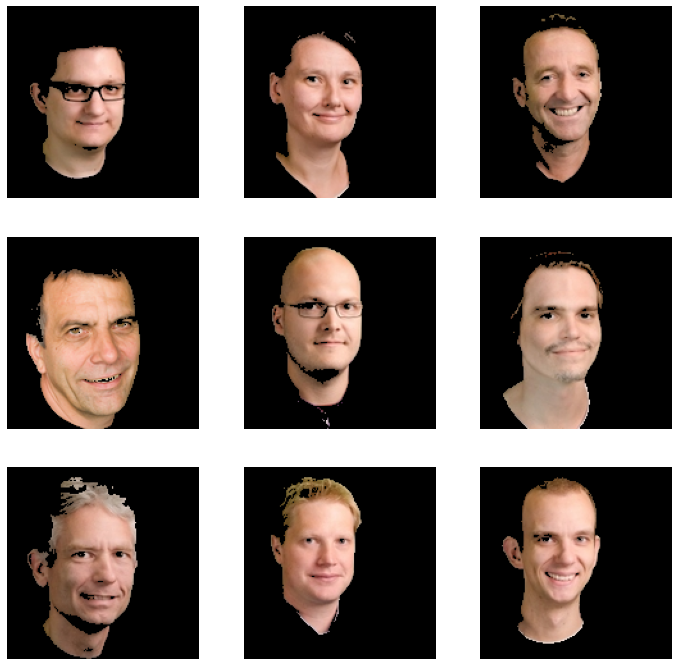

In [65]:
imgs = [cv.imread(image, cv.IMREAD_COLOR) for image in images]
masks = [np.zeros(img.shape, np.uint8) for img in imgs]

for img, mask in zip(imgs, masks):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if is_skin(img[i, j]):
                mask[i, j] = (255, 255, 255)

for i in range(len(imgs)):
    imgs[i] = np.where(masks[i] == (255, 255, 255), imgs[i], np.zeros(imgs[i].shape, np.uint8))
        
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
    for j in range(3):
        ax = axs[i, j]
        ax.axis('off')
        ax.imshow(cv.cvtColor(imgs[i * 3 + j], cv.COLOR_BGR2RGB))

### Hinweise

#### Teil 1
* Was passiert bei der Normierung (Berechnung von r und g) von einem schwarzen Pixel?

#### Teil 2
* Beachten Sie die Reihenfolge der Farbkanäle! Diese ist BGR in OpenCV
* Zur Visualisierung eignet es sich entweder ein Grauwertbild zu erstellen auf dem die entsprechenden Koordinaten weiß gefärbt werden oder die Funktion [scatter](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.scatter.html) von matplotlib zu verwenden

#### Teil 3
* Welche Punkte des Skin-Locus sollten auf jeden Fall von der Parabel getroffen werden.
* Wie viele Punkte braucht man, um die Parameter der Parabeln eindeutig zu bestimmen.

#### Teil 5
* Beachten Sie wieder die Reihenfolge der Farbkanäle (BGR)